In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
import itertools
import importlib
import time

In [3]:
from training import toy
importlib.reload(toy)
torch.manual_seed(42)

batch_size = 2

trainset = toy.CubicToyDataset(min=-4, max=4, sample_count=20, noise=3, normalize=True)
#trainset = toy.TrigonometricToyDataset(sample_count=200, normalize=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

device = torch.device("cpu")

In [4]:
import matplotlib.pyplot as plt

def plot(eval):
    plt.xlim(-6, 6)
    plt.ylim(-150, 250)
    t = torch.linspace(-6, 6, 50)
    #plt.xlim(-0.2, 1.2)
    #plt.ylim(-0.4, 1.2)
    #t = torch.linspace(-0.2, 1.2, 100)

    plt.plot(t, trainset.eval_value(t), color="blue") # Actual function

    means, variances = torch.zeros(len(t)), torch.zeros(len(t))
    with torch.no_grad():
        means, variances = eval(torch.unsqueeze(t * trainset.x_norm, -1))
    means = torch.squeeze(means, -1) / trainset.y_norm
    variances = torch.squeeze(variances, -1) / trainset.y_norm**2

    higher_bound = means + 3 * torch.sqrt(variances)
    lower_bound = means - 3 * torch.sqrt(variances)
    plt.plot(t, means, color="red") # Averaged predictions
    plt.fill_between(t, lower_bound, higher_bound, color="lightgrey")
    print(f"RMSE {torch.sqrt(F.mse_loss(means, t**3))}")

    xs, ys = zip(*(((x / trainset.x_norm).numpy(), (y / trainset.y_norm).numpy()) for (x, y) in trainset))
    plt.scatter(xs, ys, s=4, color="blue")

Epoch 0: loss 0.06276226788759232
Epoch 10: loss 0.004310928750783205
Epoch 20: loss 0.004068033304065466
Epoch 30: loss 0.003353225765749812
Epoch 40: loss 0.0029196643736213446
Epoch 50: loss 0.0027603369671851397
Epoch 60: loss 0.0026047970168292522
Epoch 70: loss 0.0025352798402309418
Epoch 80: loss 0.0020983328577131033
Epoch 90: loss 0.00243542087264359
Epoch 100: loss 0.002218063222244382
Epoch 110: loss 0.0023478984367102385
Epoch 120: loss 0.0018290377920493484
Epoch 130: loss 0.0016397156286984682
Epoch 140: loss 0.0017312702257186174
Epoch 150: loss 0.0016834298148751259
Epoch 160: loss 0.0014530480839312077
Epoch 170: loss 0.0014807768166065216
Epoch 180: loss 0.0012788065942004323
Epoch 190: loss 0.0015700910007581115
Epoch 200: loss 0.0012962870532646775
Epoch 210: loss 0.0011554148513823748
Epoch 220: loss 0.0011103235883638263
Epoch 230: loss 0.001233695656992495
Epoch 240: loss 0.0010927683906629682
Epoch 250: loss 0.001144066802226007
Epoch 260: loss 0.001279535936191

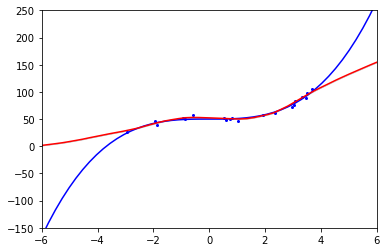

In [13]:
# Point estimator with L2 regularization

torch.manual_seed(42)

model = nn.Sequential(
    nn.Linear(1, 100), 
    nn.ReLU(),
    nn.Linear(100, 1)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)
for epoch in range(1000):
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")
plot(lambda input: (model(input), torch.tensor(0)))

Epoch 0: loss 0.06276226788759232
Epoch 10: loss 0.004310928750783205
Epoch 20: loss 0.004068033304065466
Epoch 30: loss 0.003353225765749812
Epoch 40: loss 0.0029196643736213446
Epoch 50: loss 0.0027603369671851397
Epoch 60: loss 0.0026047970168292522
Epoch 70: loss 0.0025352798402309418
Epoch 80: loss 0.0020983328577131033
Epoch 90: loss 0.00243542087264359
Epoch 100: loss 0.002218063222244382
Epoch 110: loss 0.0023478984367102385
Epoch 120: loss 0.0018290377920493484
Epoch 130: loss 0.0016397156286984682
Epoch 140: loss 0.0017312702257186174
Epoch 150: loss 0.0016834298148751259
Epoch 160: loss 0.0014530480839312077
Epoch 170: loss 0.0014807768166065216
Epoch 180: loss 0.0012788065942004323
Epoch 190: loss 0.0015700910007581115
Epoch 200: loss 0.0012962870532646775
Epoch 210: loss 0.0011554148513823748
Epoch 220: loss 0.0011103235883638263
Epoch 230: loss 0.001233695656992495
Epoch 240: loss 0.0010927683906629682
Epoch 250: loss 0.001144066802226007
Epoch 260: loss 0.001279535936191

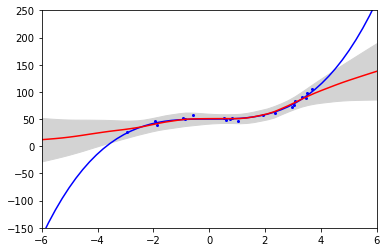

In [14]:
# SWAG trained with SGD and L2 regularization (lr is currently not adjusted for SWAG)

from training import swag
importlib.reload(swag)

torch.manual_seed(42)

model = nn.Sequential(nn.Linear(1, 100), nn.ReLU(), nn.Linear(100, 1))
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001) # Without weight_decay the covariance matrix is not positive definit???
wrapper = swag.SWAGWrapper(model, 5, 10)

for epoch in range(1000):
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    wrapper.update(epoch)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")

def eval_swag(input):
    return wrapper.sample(input, 100, model, 1)

plot(eval_swag)

Training model 0
  Final loss -2.530033588409424
Training model 1
  Final loss -2.449371814727783
Training model 2
  Final loss -2.5732932090759277
Training model 3
  Final loss -2.320618152618408
Training model 4
  Final loss -2.2541844844818115
RMSE 90.8624038696289


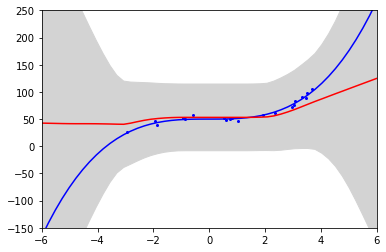

In [15]:
# Ensemble of point estimators with L2 regularization

from training import ensemble
importlib.reload(ensemble)

torch.manual_seed(42)

adversarial_training = True

def nll_loss(mean, variance, target):
    return (torch.log(variance) / 2 + torch.pow(target - mean, 2) / (2 * variance)).sum() / mean.shape[0]

ensemble_count = 5
models = [nn.Sequential(nn.Linear(1, 100), nn.ReLU(), nn.Linear(100, 2)) for _ in range(ensemble_count)]

for i, model in enumerate(models):
    print(f"Training model {i}")
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)
    for epoch in range(1000):
        epoch_loss = torch.tensor(0, dtype=torch.float)
        for data, target in trainloader:
            optimizer.zero_grad()
            if adversarial_training:
                data.requires_grad = True

            output = model(data)
            mean, variance = output[:, 0], torch.log1p(torch.exp(output[:, 1])) + 1e-6
            loss = nll_loss(mean, variance, target)

            if adversarial_training:
                loss.backward(retain_graph=True)
                a_data = data + 0.01 * torch.sign(data.grad)
                optimizer.zero_grad()
                a_output = model(data)
                a_mean, a_variance = a_output[:, 0], torch.log1p(torch.exp(a_output[:, 1])) + 1e-6
                a_loss = nll_loss(a_mean, a_variance, target)
                loss += a_loss

            loss.backward()
            optimizer.step()
            epoch_loss += loss
        #if epoch % 10 == 0:
            #print(f"  Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
    print(f"  Final loss {epoch_loss / (len(trainloader) * batch_size)}")


def eval_esemble(input):
    return ensemble.combined_variance_output(input, models)


plot(eval_esemble)

Epoch 0: loss 27.881534576416016
Epoch 10: loss 27.727001190185547
Epoch 20: loss 27.712636947631836
Epoch 30: loss 27.706573486328125
Epoch 40: loss 27.707305908203125
Epoch 50: loss 27.706554412841797
Epoch 60: loss 27.697296142578125
Epoch 70: loss 27.694271087646484
Epoch 80: loss 27.694530487060547
Epoch 90: loss 27.692672729492188
Final loss 27.692195892333984
RMSE 103.03067779541016


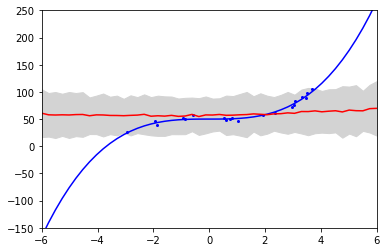

In [41]:
# Bayesian NN (Bayes-by-Backprop)

from training import bbb, util
importlib.reload(bbb)
importlib.reload(util)

torch.manual_seed(42)

pi = 0.5  # 0.25, 0.5, 0.75
sigma1 = np.exp(-1)  # 0, 1, 2
sigma2 = np.exp(-7)  # 6, 7, 8
#prior = util.GaussianMixture(pi, sigma1, sigma2)
prior = torch.distributions.Normal(0, 1.0)

model = nn.Sequential(
    bbb.BBBLinear(1, 100, prior, prior, device),
    nn.ReLU(),
    bbb.BBBLinear(100, 1, prior, prior, device)
)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = torch.nn.MSELoss()

for epoch in range(100):
    loss = bbb.run_bbb_epoch(model, optimizer, loss_fn, trainloader, device)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {loss / (len(trainloader) * batch_size)}")
print(f"Final loss {loss / (len(trainloader) * batch_size)}")


def eval_bbb(input):
    samples = 100
    model.eval()
    outputs = torch.stack([model(input) for _ in range(samples)])
    return torch.mean(outputs, dim=0), torch.var(outputs, dim=0)
plot(eval_bbb)

Epoch 0: loss 0.04467980936169624
Epoch 10: loss 0.025491584092378616
Epoch 20: loss 0.011275256052613258
Epoch 30: loss 0.019884509965777397
Epoch 40: loss 0.007365141063928604
Epoch 50: loss 0.005963248200714588
Epoch 60: loss 0.007431139703840017
Epoch 70: loss 0.01564166322350502
Epoch 80: loss 0.003277348354458809
Epoch 90: loss 0.0030962456949055195
Epoch 100: loss 0.004624450579285622
Epoch 110: loss 0.0029644998721778393
Epoch 120: loss 0.0058478848077356815
Epoch 130: loss 0.003893942339345813
Epoch 140: loss 0.002430899301543832
Epoch 150: loss 0.00865117646753788
Epoch 160: loss 0.004786636680364609
Epoch 170: loss 0.007330754306167364
Epoch 180: loss 0.0074948533438146114
Epoch 190: loss 0.0047861123457551
Epoch 200: loss 0.003490084782242775
Epoch 210: loss 0.00253454246558249
Epoch 220: loss 0.005719298962503672
Epoch 230: loss 0.0014056944055482745
Epoch 240: loss 0.0023143328726291656
Epoch 250: loss 0.006737306714057922
Epoch 260: loss 0.003355275373905897
Epoch 270: l

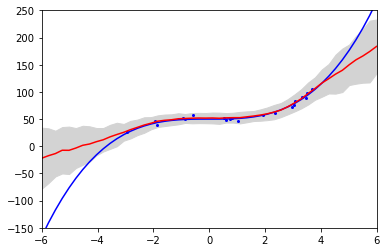

In [12]:
# MC dropout

torch.manual_seed(42)

p = 0.3

model = nn.Sequential(
    nn.Linear(1, 300), 
    nn.ReLU(), 
    nn.Dropout(p),
    nn.Linear(300, 1),
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for epoch in range(1000):
    model.train()
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for data, target in trainloader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {epoch_loss / (len(trainloader) * batch_size)}")
print(f"Final loss {epoch_loss / (len(trainloader) * batch_size)}")

def eval_dropout(input):
    samples = 100
    model.train() # Enable dropout
    outputs = torch.stack([model(input) for _ in range(samples)])
    return torch.mean(outputs, dim=0), torch.var(outputs, dim=0)

plot(eval_dropout)

Epoch 0: loss 20.950979232788086
Epoch 10: loss 25.771841049194336
Epoch 20: loss 24.59365463256836
Epoch 30: loss 23.77509307861328
Epoch 40: loss 23.10057258605957
Epoch 50: loss 22.82136344909668
Epoch 60: loss 22.065271377563477
Epoch 70: loss 21.722579956054688
Epoch 80: loss 21.278268814086914
Epoch 90: loss 20.914342880249023
Epoch 100: loss 21.060779571533203
Epoch 110: loss 22.978797912597656
Epoch 120: loss 23.876680374145508
Epoch 130: loss 26.64859962463379
Epoch 140: loss 29.45884132385254
Epoch 150: loss 30.383739471435547
Epoch 160: loss 29.942901611328125
Epoch 170: loss 29.087717056274414
Epoch 180: loss 30.089080810546875
Epoch 190: loss 34.05482482910156
Epoch 200: loss 33.865684509277344
Epoch 210: loss 32.78288269042969
Epoch 220: loss 31.29656410217285
Epoch 230: loss 37.08175277709961
Epoch 240: loss 39.00708770751953
Epoch 250: loss 37.02607345581055
Epoch 260: loss 35.25570297241211
Epoch 270: loss 33.818233489990234
Epoch 280: loss 33.44963455200195
Epoch 290:

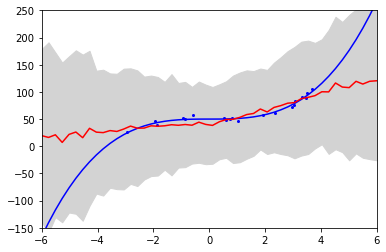

In [14]:
# Bayesian NN (Bayes-by-Backprop)

from training import bbb, util
importlib.reload(bbb)
importlib.reload(util)

torch.manual_seed(42)

pi = 0.5  # 0.25, 0.5, 0.75
sigma1 = np.exp(-1)  # 0, 1, 2
sigma2 = np.exp(-7)  # 6, 7, 8
prior = util.GaussianMixture(pi, sigma1, sigma2)
#prior = torch.distributions.Normal(0, 1.0)

model = nn.Sequential(
    bbb.BBBLinear(1, 100, prior, prior, device, mc_sample=2),
    nn.ReLU(),
    bbb.BBBLinear(100, 1, prior, prior, device, mc_sample=2)
)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()

for epoch in range(500):
    loss = bbb.run_bbb_epoch(model, optimizer, loss_fn, trainloader, device)
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss {loss / (len(trainloader) * batch_size)}")
print(f"Final loss {loss / (len(trainloader) * batch_size)}")


def eval_bbb(input):
    samples = 100
    model.eval()
    outputs = torch.stack([model(input) for _ in range(samples)])
    return torch.mean(outputs, dim=0), torch.var(outputs, dim=0)
plot(eval_bbb)